In [2]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set the path to the folder containing the incident folders
data_path = "/content/drive/MyDrive/Dataset for test"

# Get the list of folders (classes)
folders = os.listdir(data_path)

# Initialize empty lists for images and labels
images = []
labels = []

# Load images and labels
for folder in folders:
    folder_path = os.path.join(data_path, folder)
    image_files = os.listdir(folder_path)
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed for InceptionV3
        image = img_to_array(image)
        images.append(image)
        labels.append(folder)

# Convert lists to arrays
images = np.array(images)
labels = np.array(labels)

# Encode the labels as integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

np.save('label_encoder_classes.npy', label_encoder.classes_)

# Split the data into training and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Normalize the image data
train_images = train_images / 255.0
test_images = test_images / 255.0

# Apply additional data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    shear_range=0.25,  # Randomly apply shearing transformations
    zoom_range=0.2,
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False  # Randomly flip images vertically
)

# Fit the data augmentation generator on the training data
datagen.fit(train_images)

# Define the InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Use InceptionV3 instead

# Freeze the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(folders), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model4weights.h5', monitor='val_accuracy', save_best_only=True)

# Train the model with augmented data and callbacks
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32), epochs=60, validation_data=(test_images, test_labels), callbacks=[early_stopping, checkpoint])

# Load the best weights
model.load_weights('/content/drive/MyDrive/best_model4weights.h5')

# Evaluate the model on the training data
train_loss, train_acc = model.evaluate(train_images, train_labels)
print("Train accuracy:", train_acc)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy:", test_acc)

Epoch 1/60
226/226 [==============================] - 117s 499ms/step - loss: 0.6501 - accuracy: 0.7855 - val_loss: 0.4051 - val_accuracy: 0.8662
Epoch 2/60
226/226 [==============================] - 112s 496ms/step - loss: 0.4395 - accuracy: 0.8473 - val_loss: 0.3929 - val_accuracy: 0.8690
Epoch 3/60
226/226 [==============================] - 111s 492ms/step - loss: 0.3948 - accuracy: 0.8630 - val_loss: 0.3408 - val_accuracy: 0.8978
Epoch 4/60
226/226 [==============================] - 110s 484ms/step - loss: 0.3755 - accuracy: 0.8705 - val_loss: 0.3345 - val_accuracy: 0.8956
Epoch 5/60
226/226 [==============================] - 110s 488ms/step - loss: 0.3351 - accuracy: 0.8821 - val_loss: 0.4141 - val_accuracy: 0.8840
Epoch 6/60
226/226 [==============================] - 115s 510ms/step - loss: 0.3422 - accuracy: 0.8839 - val_loss: 0.3342 - val_accuracy: 0.8973
Epoch 7/60
226/226 [==============================] - 130s 576ms/step - loss: 0.3370 - accuracy: 0.8845 - val_loss: 0.3648 -

In [3]:
# Make predictions on the test data
y_pred = np.argmax(model.predict(test_images), axis=-1)

# Calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(test_labels, y_pred, average='weighted')
recall = recall_score(test_labels, y_pred, average='weighted')
f1 = f1_score(test_labels, y_pred, average='weighted')

# Print the results
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 score: {:.3f}".format(f1))

57/57 [==============================] - 14s 224ms/step
Precision: 0.910
Recall: 0.906
F1 score: 0.906


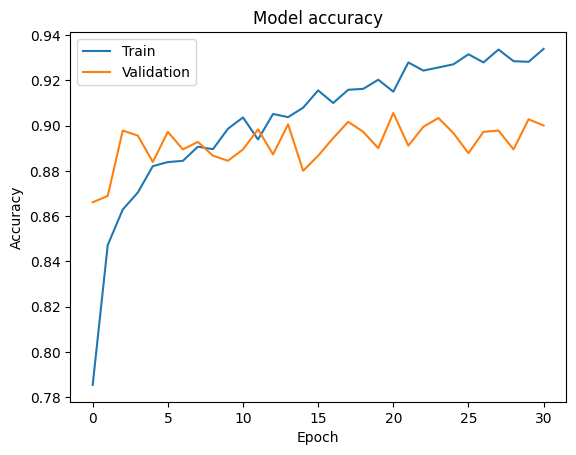

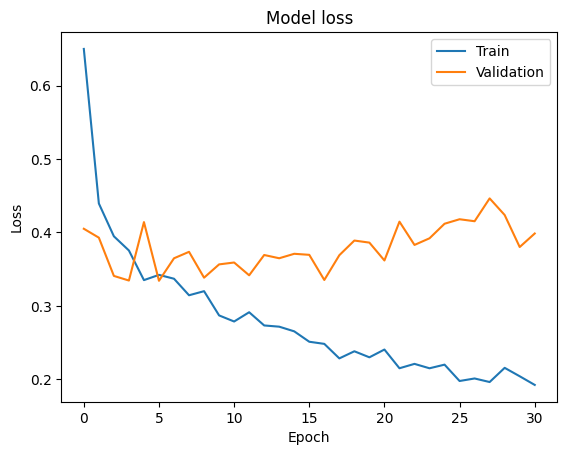

In [4]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the new image
new_image_path = "/content/drive/MyDrive/1.jpg"  # Replace with the path to your new image
new_image = load_img(new_image_path, target_size=(224, 224))  # Adjust target size as needed
new_image = img_to_array(new_image)
new_image = new_image / 255.0  # Normalize the pixel values

# Reshape the image to match the model's input shape
new_image = np.expand_dims(new_image, axis=0)

# Make a prediction
predictions = model.predict(new_image)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Decode the predicted class index to obtain the label
predicted_label = label_encoder.inverse_transform([predicted_class_index])

# Print the predicted label
print("Predicted label:", predicted_label)

1/1 [==============================] - 0s 47ms/step
Predicted label: ['Fire and explosions - Severity 1']


In [26]:
from sklearn.metrics import confusion_matrix, classification_report

# Get the predicted labels for the test data
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_mat = confusion_matrix(test_labels, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(conf_mat)

# Compute the classification report, which includes precision, recall, and F1 score for each class
class_names = label_encoder.classes_
cls_report = classification_report(test_labels, y_pred, target_names=class_names)
print("Classification report:")
print(cls_report)

57/57 [==============================] - 13s 227ms/step
Confusion matrix:
[[ 69  10   0   1   3   6   0]
 [  0 219   1   2   9   3   0]
 [  0   3 273   1  17   1   0]
 [  1   6   1 186   8   5   0]
 [  3  13   9   5 582   7   1]
 [  1   1   1   0   4 187  12]
 [  0   0   0   0   0  35 115]]
Classification report:
                                  precision    recall  f1-score   support

       Fallen Trees - Severity 2       0.93      0.78      0.85        89
       Fallen Tress - Severity 1       0.87      0.94      0.90       234
Fire and explosions - Severity 1       0.96      0.93      0.94       295
          Floodings - Severity 1       0.95      0.90      0.93       207
          Normal - Severity none       0.93      0.94      0.94       620
           Potholes - Severity 1       0.77      0.91      0.83       206
           Potholes - Severity 2       0.90      0.77      0.83       150

                        accuracy                           0.91      1801
                 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

app = Flask(__name__)
model = load_model('best_model4weights.h5')
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('label_encoder_classes_2.npy')
import base64
from PIL import Image
from io import BytesIO

@app.route('/predict', methods=['POST'])
def predict():
    # Retrieve the image file from the request
    image_data = request.json['image']
    
    # Decode the base64 image data to bytes
    image_bytes = base64.b64decode(image_data)
    
    # Create a PIL image from the bytes
    image = Image.open(BytesIO(image_bytes))
    image = image.convert('RGB')
    image = image.resize((224, 224))
    
    # Convert the PIL image to numpy array
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    
    # Make predictions
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions)
    predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]

    # Return the prediction as JSON response
    return jsonify({'predicted_label': predicted_label})
@app.route('/')
def home():
    return 'Hello, world!'


In [8]:
if __name__ == '__main__':
    app.run(host='192.168.1.6', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://192.168.1.6:5000
Press CTRL+C to quit


1/1 [==============================] - 0s 205ms/step


192.168.1.7 - - [09/Jul/2023 00:16:45] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 54ms/step


192.168.1.7 - - [09/Jul/2023 00:17:47] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 52ms/step


192.168.1.7 - - [09/Jul/2023 00:18:40] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 51ms/step


192.168.1.7 - - [09/Jul/2023 00:20:10] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 56ms/step


192.168.1.7 - - [09/Jul/2023 00:21:27] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 53ms/step


192.168.1.7 - - [09/Jul/2023 00:26:00] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 51ms/step


192.168.1.7 - - [09/Jul/2023 00:27:31] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 55ms/step


192.168.1.7 - - [09/Jul/2023 00:38:21] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 53ms/step


192.168.1.7 - - [09/Jul/2023 00:39:54] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 49ms/step


192.168.1.7 - - [09/Jul/2023 00:42:23] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 58ms/step


192.168.1.7 - - [09/Jul/2023 00:43:26] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 58ms/step


192.168.1.7 - - [09/Jul/2023 00:46:32] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 61ms/step


192.168.1.7 - - [09/Jul/2023 00:54:52] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 56ms/step


192.168.1.7 - - [09/Jul/2023 00:56:30] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 63ms/step


192.168.1.7 - - [09/Jul/2023 00:58:11] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 69ms/step


192.168.1.7 - - [09/Jul/2023 01:33:40] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 71ms/step


192.168.1.7 - - [09/Jul/2023 01:34:48] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 62ms/step


192.168.1.7 - - [09/Jul/2023 01:35:23] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 60ms/step


192.168.1.7 - - [09/Jul/2023 01:39:36] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 105ms/step


192.168.1.7 - - [09/Jul/2023 02:23:49] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 63ms/step


192.168.1.7 - - [09/Jul/2023 02:26:06] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 58ms/step


192.168.1.7 - - [09/Jul/2023 02:30:43] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 57ms/step


192.168.1.7 - - [09/Jul/2023 02:35:34] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 67ms/step


192.168.1.7 - - [09/Jul/2023 02:36:17] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 131ms/step


192.168.1.7 - - [09/Jul/2023 03:14:40] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 61ms/step


192.168.1.7 - - [09/Jul/2023 03:18:31] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 56ms/step


192.168.1.7 - - [09/Jul/2023 03:23:32] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 55ms/step


192.168.1.7 - - [09/Jul/2023 03:25:25] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 57ms/step


192.168.1.7 - - [09/Jul/2023 03:30:19] "POST /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 51ms/step


192.168.1.7 - - [09/Jul/2023 03:31:28] "POST /predict HTTP/1.1" 200 -
